In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
%matplotlib inline

# Unit 3.5.2 Gradient Boost

Ensemble models combine many less effective models (“weak learners”) into one more effective model (“strong learner”). Random forests are a type of bagged ensemble model where many models are run in parallel and their outputs are aggregated. Another class of ensemble models, Boosting Models, models the data over and over, each time adjusting the model based on what was learned from the previous one.

We start by fitting a simple model on all the data. We identify the information that the model was not able to account for (incorrect predictions in classifier, and residuals in regression) and build a new simple model that targets that new pool of information. We repeat this until we reach some predetermined stopping rule. The combination of all the models is then used to make the final predictions.

Boosting is great because we can use many simple models that are each computationally fast to arrive at very accurate predictions. There are many different implementations of boosting that vary along the following axes:

- Type of simple model. You can use almost any model you like.

- Index of error. You can use residuals from regression, classification errors, or any cost function.

- How the next iteration targets the error. You can weight inaccurately-predicted cases high and accurately-predicted cases low, you can directly model residuals, or you can model only the subset of the data that was inaccurately predicted.

- Stopping rule. You can stop once you've run a certain number of models, once the amount of variance explained by the most recent iteration of the model is lower than some threshold, or once the change in weights between the two most recent model iterations is lower than some threshold.

We'll cover the most commonly-used implementation: **gradient boosting.**

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes. In gradient boosting, however, the underlying data do change. Let's work it out:

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters. Most often, however, gradient boosting uses decision trees, and minimizes either the residual (regression trees) or the negative log-likelihood (classification trees).



### Gradient boosting with regression trees

The loss function to minimize is the sum of the squared residuals:

$$\frac1{n}\sum_{i=1}^n(y_i-(\alpha + \beta x_i))^2$$

(Though it can also be the sum of the absolute value of the residuals, as in lasso regression.)

Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

The decision trees we use can be very simple.  In the example below, the decision trees only have a max depth of 2, meaning a maximum of four leaves.  These weak learners do not have to perform well at all individually in order to do well in aggregate.  

Here we're going to do gradient boosting with regression trees by hand.  Our goal is to predict the variable "happy" using all the other variables in the European Social Survey dataset.  We'll calculate a tree, store the predicted values, pull the residuals, and run a new tree on the residuals.  This will repeat 101 times.  At the end, we add together all the predicted values from each iteration to yield the final predictions.

In [6]:
# Working with the European Social Survey data again.
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Define outcome and predictors.
y = df['happy']
X = df.loc[:, ~df.columns.isin(['happy', 'cntry'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

X.head()

,idno,year,tvtot,ppltrst,pplfair,pplhlp,sclmeet,sclact,gndr,agea,partner,CH,CZ,DE,ES,NO,SE
0,5.0,6,3.0,3.0,10.0,5.0,5.0,4.0,2.0,60.0,1.0,1,0,0,0,0,0
1,25.0,6,6.0,5.0,7.0,5.0,3.0,2.0,2.0,59.0,1.0,1,0,0,0,0,0
2,26.0,6,1.0,8.0,8.0,8.0,6.0,3.0,1.0,24.0,2.0,1,0,0,0,0,0
3,28.0,6,4.0,6.0,6.0,7.0,6.0,2.0,2.0,64.0,1.0,1,0,0,0,0,0
4,29.0,6,5.0,6.0,7.0,5.0,7.0,2.0,2.0,55.0,1.0,1,0,0,0,0,0


Weak learner 0 R^2: -21.86595826514709
Weak learner 20 R^2: -0.0026192923008196978
Weak learner 40 R^2: -0.0016748172727345523
Weak learner 60 R^2: -0.0014818633549413818
Weak learner 80 R^2: -0.0012578370480087475
Weak learner 100 R^2: -0.0007136861925909344


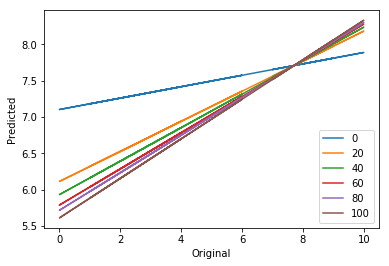

Overall R^2:
0.528287358179


,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,...,pred91,pred92,pred93,pred94,pred95,pred96,pred97,pred98,pred99,pred100
0,8.168311,0.013769,-0.029901,0.181363,0.104414,-0.030160,-0.120018,-0.013159,0.301909,-0.002564,...,-0.012236,0.015056,-0.012845,0.001085,-0.008118,0.002566,-0.010875,-0.001109,-0.202222,0.235428
1,7.633021,0.013769,-0.029901,0.181363,-0.235860,0.163699,-0.120018,-0.013159,-0.008157,-0.002564,...,-0.012236,0.015056,-0.012845,0.001085,0.074060,0.002566,-0.010875,-0.001109,-0.202222,0.235428
2,8.168311,0.198944,0.434040,0.520883,0.104414,-0.000255,0.136552,-0.013159,-0.008157,-0.183307,...,-0.012236,0.015056,-0.012845,0.001085,-0.008118,0.002566,0.044827,0.011030,-0.202222,0.235428
3,7.633021,0.389182,-0.029901,0.181363,-0.235860,0.163699,0.076182,-0.013159,-0.008157,-0.002564,...,-0.012236,0.015056,-0.012845,0.001085,-0.008118,0.002566,-0.010875,-0.001109,-0.001848,0.235428
4,7.633021,0.389182,-0.029901,0.181363,-0.235860,0.163699,-0.120018,-0.013159,-0.008157,0.096519,...,-0.012236,0.015056,-0.012845,0.001085,-0.008118,0.002566,-0.010875,-0.001109,-0.001848,0.235428


In [7]:
# Store values from loops.
preds = pd.DataFrame()
labels = []

uniquex = df['happy'].unique()

# Iterate through decision trees, each time using the residuals
# from the previous tree as the inputs.
for m in range(0, 101):
    
    # Initialize and fit the tree. Set the max depth to 2.
    decision_tree = tree.DecisionTreeRegressor(max_depth=2)
    decision_tree.fit(X,y)
    
    # Get and store predicted values.
    pred = decision_tree.predict(X)
    preds['pred{}'.format(m)] = pred
    
    # Residuals.
    y = y - pred

    # Output every 20 iterations.
    if m % 20 == 0:
        print('Weak learner {} R^2: {}'.format(m, decision_tree.score(X, y)))
        labels = labels + [m]
        bestpred = preds.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(df['happy'], bestpred, 1))(uniquex))
       
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted = preds.sum(axis=1)

print('Overall R^2:')
print(np.corrcoef(df['happy'], predicted)[0, 1])

preds.head()

Looking at the sampling of individual model $R^2$, these are certainly 'weak learners'!  They perform very badly indeed.  Yet in aggregate, the models are able to explain nearly 53% of the variance in happiness in the dataset.  This is a great example of the power of gradient boosting.  You may also note from the plot that the greatest gains happened in the earliest models, with subsequent steps yielding smaller gains in explanatory power.

But maybe we could do just as well with one big decision tree, rather than a bunch of small ones.  Let's try:

One strongish learner R^2: 0.06711108322936521


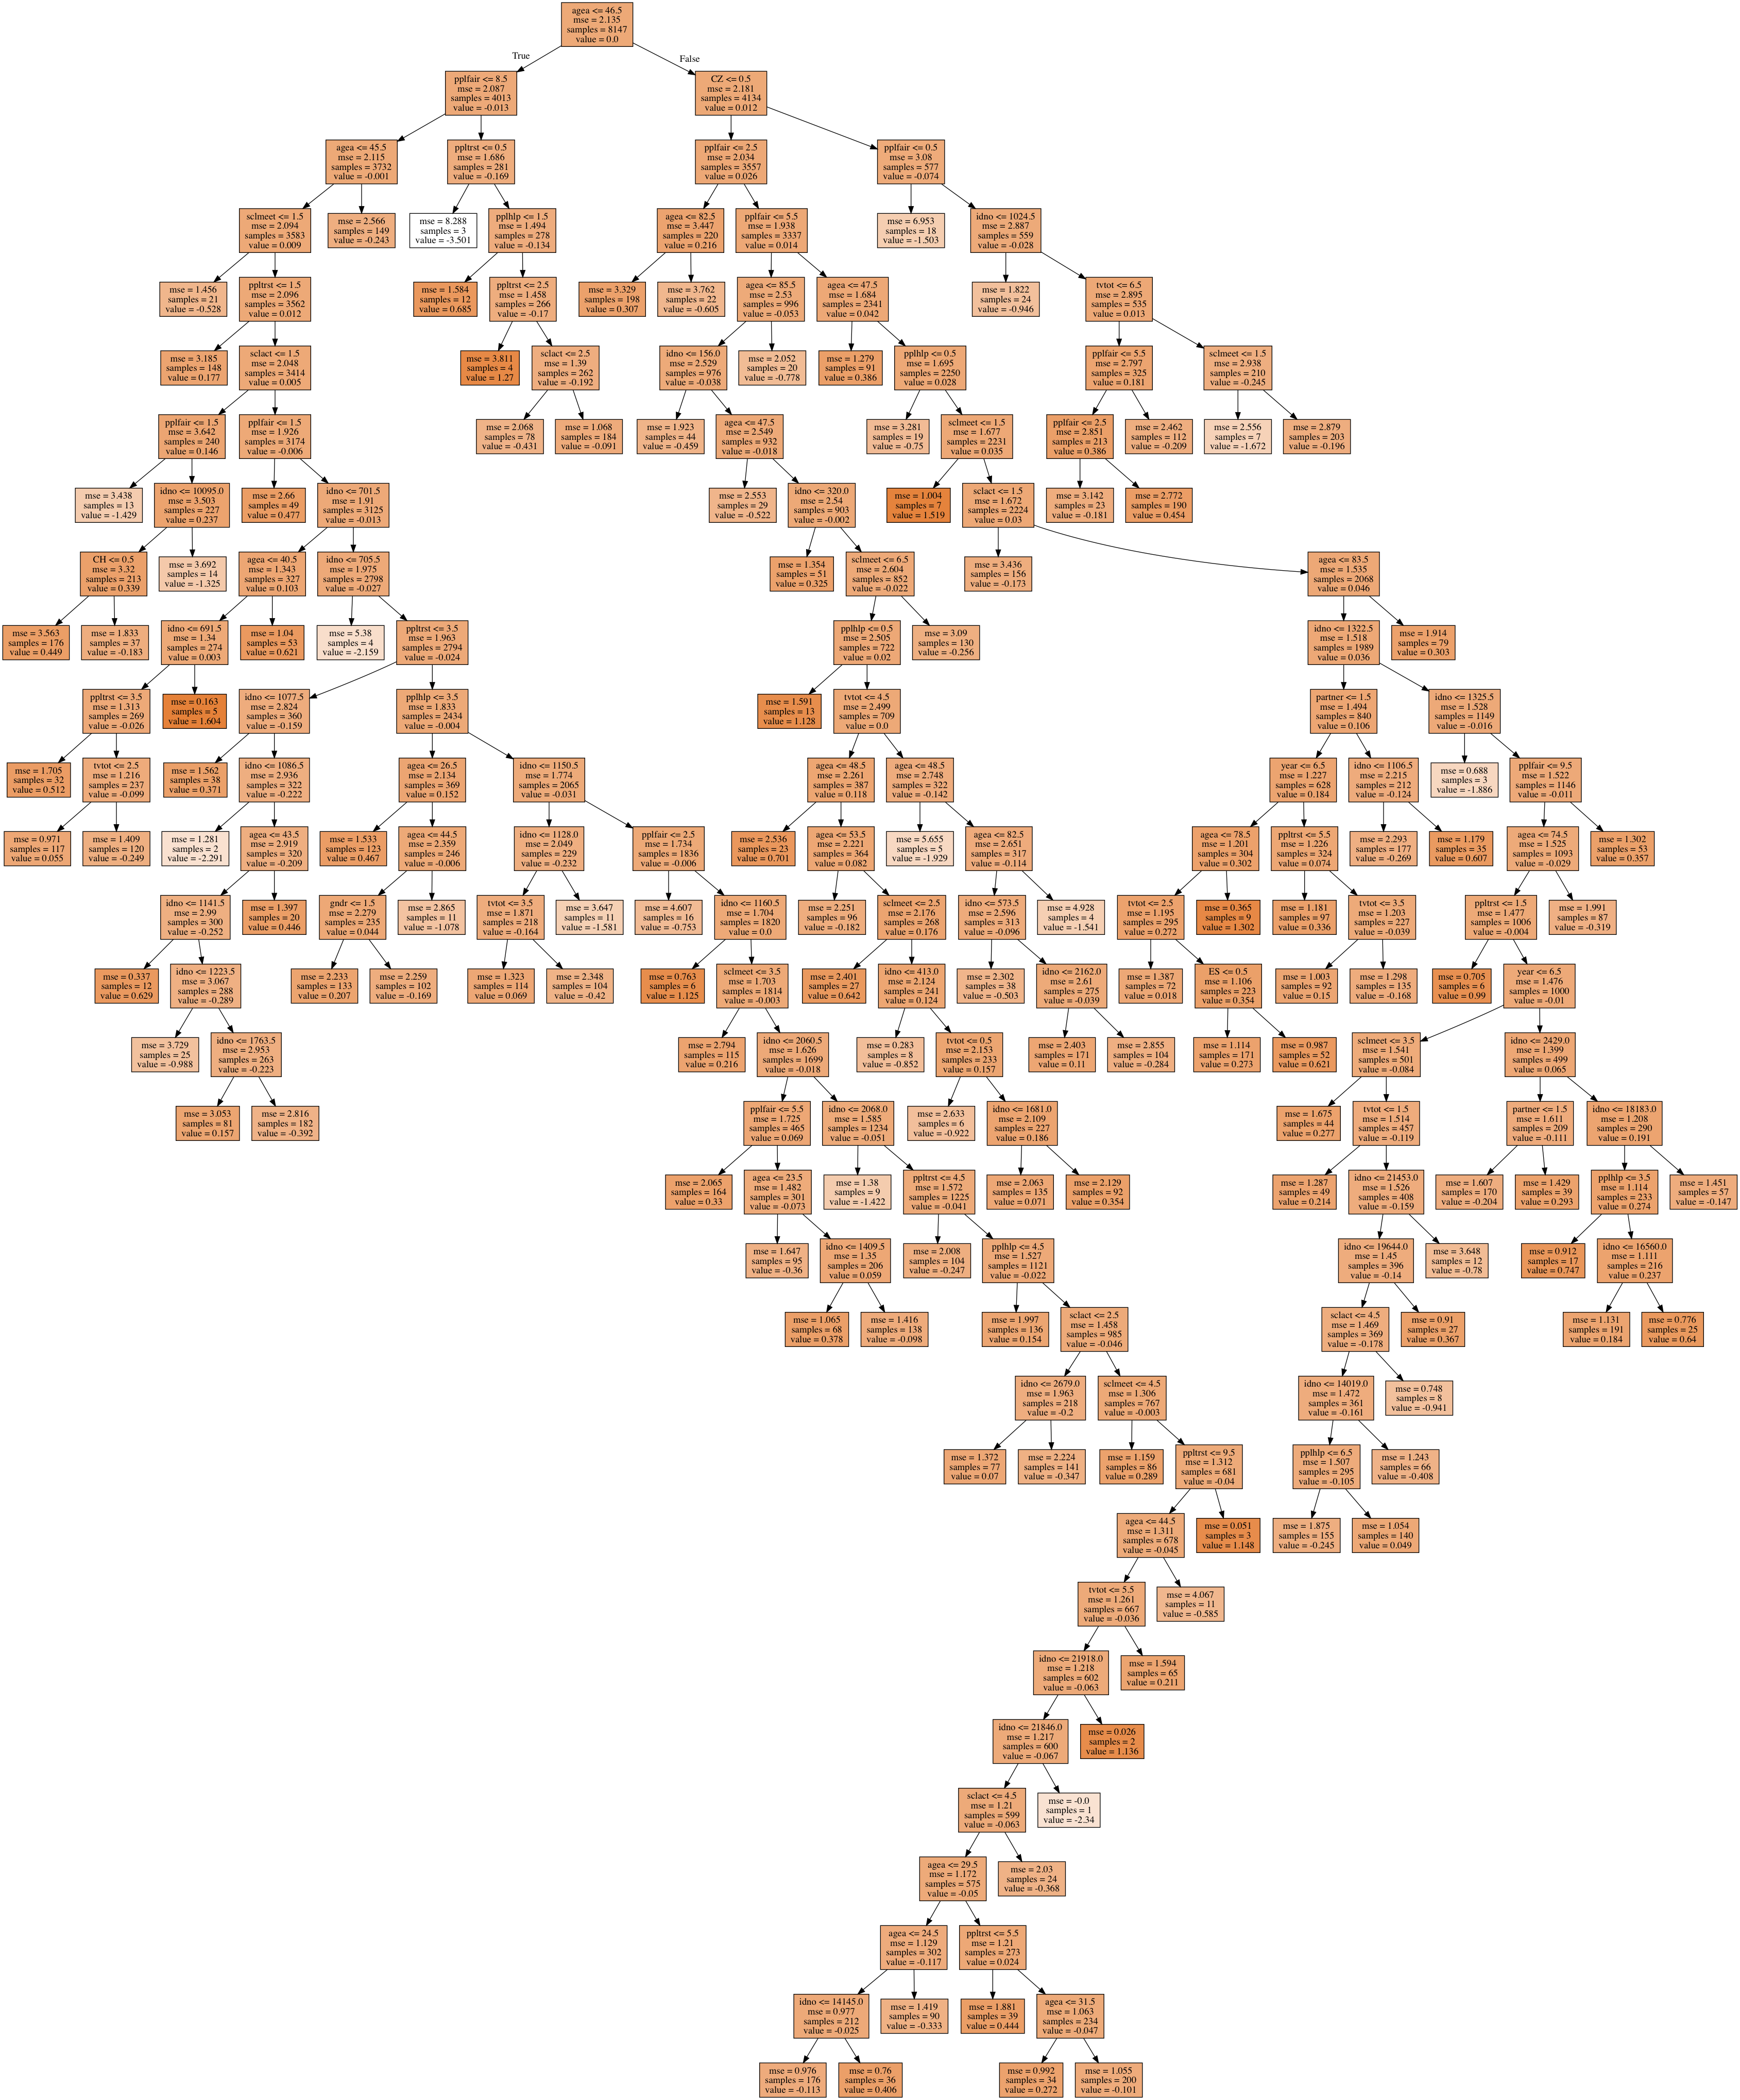

In [8]:
# One big tree. Each node split will include at lest 2.5% of the total sample.
decision_tree = tree.DecisionTreeRegressor(min_samples_split=.025)
decision_tree.fit(X,y)

#Get and store predicted values.
pred = decision_tree.predict(X)
print('One strongish learner R^2: {}'.format(decision_tree.score(X, y)))

dot_data = tree.export_graphviz(decision_tree, out_file=None,
                                feature_names=X.columns,  
                                filled=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())  

Well that didn't work at all.  Gradient boosting with weak learners was nearly 10 times more effective as one complex decision tree.  In fact, in many instances gradient boosted decision trees perform better than random forests.  They are also less prone to overfitting than individual decision trees.

### Overfitting

Still, it is easy to see that the more iterations we run, the more likely we are to overfit.  Gradient boost comes with some methods to avoid overfitting.  Cross-validation will check for overfitting, but there are also methods that can be applied before using the test set that will reduce the likelihood of overfit.  

One option is **subsampling**, where each iteration of the boost algorithm uses a subsample of the original data.  By introducing some randomness into the process, subsampling makes it harder to overfit.

Another option is shrinkage, which we have encountered before in ridge regression.  Here, the shrinkage/regularization parameter reduces the impact of subsequent iterations on the final solution.  Visually, you can picture this parameter, called the "learning rate", causing each "step" along the loss function gradient to be a little smaller than the previous one.  This prevents any one iteration from being too influential and misdirecting the overall boost solution.  Learning rates vary between 0 (only the initial iteration matters) to 1 (all iterations are weighted equally).  A model made up of many small steps is less prone to overfitting than a model made up of few large steps, but it can also lead to much slower running times, depending on the stopping rule in play.

In the next assignment, we'll try gradient boosting using the SKLearn package, which comes with all sorts of helpful features for getting the most out of gradient boost.

# Unit 3.5.3 Guided example and challenge



In [9]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [55]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

In [32]:
# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [11]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

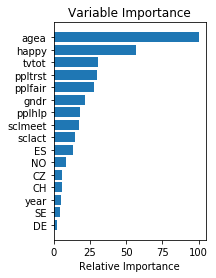

In [13]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [27]:
X.year.unique()

array([6, 7])

In [42]:
# Combining ppl and scl columns through addition.  (The subtopics are highly correlated.)

X2 = X
X2['ppl_feel'] = X[['ppltrst','pplfair','pplhlp']].sum(axis=1)
X2 = X2.drop(['ppltrst','pplfair','pplhlp'],axis=1)

X2['scl_tot'] = X[['sclmeet','sclact']].sum(axis=1)
X2 = X2.drop(['sclmeet','sclact','year'],axis=1)

X2.head()

,tvtot,happy,gndr,agea,CH,CZ,DE,ES,NO,SE,ppl_feel,scl_tot
0,3.0,8.0,2.0,60.0,1,0,0,0,0,0,18.0,9.0
1,6.0,9.0,2.0,59.0,1,0,0,0,0,0,17.0,5.0
2,1.0,7.0,1.0,24.0,1,0,0,0,0,0,24.0,9.0
3,4.0,10.0,2.0,64.0,1,0,0,0,0,0,19.0,8.0
4,5.0,8.0,2.0,55.0,1,0,0,0,0,0,18.0,9.0


In [34]:
# Create training and test sets.
offset = int(X2.shape[0] * 0.9)

# Put 90% of the data in the training set.
X2_train, y2_train = X2[:offset], y[:offset]

# And put 10% in the test set.
X2_test, y2_test = X2[offset:], y[offset:]

In [35]:
# Increasing to 700 iterations, use 4-deep trees
params = {'n_estimators': 700,
          'max_depth': 4,
          'loss': 'exponential',
         }

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X2_train, y2_train)

predict_train = clf.predict(X2_train)
predict_test = clf.predict(X2_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.022776868521549372
Percent Type II errors: 0.11988543371522095

Test set accuracy:
Percent Type I errors: 0.0785276073619632
Percent Type II errors: 0.18404907975460122


In [43]:
# Changing learning rate to 0.01
params = {'learning_rate': 1,
          'max_depth': 4,
          'loss': 'exponential',
         }

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X2_train, y2_train)

predict_train = clf.predict(X2_train)
predict_test = clf.predict(X2_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.03627932351336607
Percent Type II errors: 0.10815602836879433

Test set accuracy:
Percent Type I errors: 0.10429447852760736
Percent Type II errors: 0.18159509202453988


In [56]:
# Utilizing subsampling
params = {'learning_rate': 1,
          'max_depth': 4,
          'loss': 'exponential',
          'subsample':0.4
         }

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X2_train, y2_train)

predict_train = clf.predict(X2_train)
predict_test = clf.predict(X2_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.08742498636115657
Percent Type II errors: 0.13434260774686307

Test set accuracy:
Percent Type I errors: 0.12024539877300613
Percent Type II errors: 0.16441717791411042
